<a href="https://colab.research.google.com/github/golnazads/ColabNotebooks/blob/main/LLM_KG_Apollo_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Necessary Packages and Import Libraries

This section covers the installation of required Python packages and the importing of necessary libraries for the experiment.

In [ ]:
!pip install pandas openai sentence-transformers leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  U

In [ ]:
import os
from collections import defaultdict
import re
import json
import logging
import igraph as ig
from openai import OpenAI
import pandas as pd
import numpy as np
import csv
import leidenalg
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Define System and User Prompts for Fine-Tuning

In this section, we define the system and user prompts used to fine-tune the GPT-4o language model. The prompts include examples to help the model adapt to the specific terminology, writing styles, and context of astronomical literature, particularly focusing on Apollo craters and Apollo missions.

In [ ]:
# ENTITY TYPES:
entity_types = {
  "instrument": "https://www.wikidata.org/wiki/Q751997",  # astronomical instrument
  "telescope": "https://www.wikidata.org/wiki/Q148578", # space telescope
  "mission": "https://www.wikidata.org/wiki/Q2133344",  # space mission
  "celestialObject": "https://www.wikidata.org/wiki/Q6999", # astronomical object
  "celestialRegion": "https://www.wikidata.org/wiki/Q203218",  # spherical coordinate system
  "celestialObjectRegion": "https://www.wikidata.org/wiki/Q12134",  # celestial sphere
  "planetaryNomenclature": "https://www.wikidata.org/wiki/Q1463003",  # planetary nomenclature: system of uniquely identifying features on the surface of a planet or natural satellite
  "spacecraft": "https://www.wikidata.org/wiki/Q40218", # spacecraft
  "measure": "https://www.wikidata.org/wiki/Q39875001", # measure: standard against which something can be judged
  "period": "https://www.wikidata.org/wiki/Q392928", # period: subdivision of geological time; shorter than an era and longer than an epoch
  "coordinate": "https://www.wikidata.org/wiki/Q3250736", # coordinate: number which characterizes position
  "research": "https://www.wikidata.org/wiki/Q42240", # research: systematic study undertaken to increase knowledge
  "data": "https://www.wikidata.org/wiki/Q42848", # data: information arranged for automatic processing
}

# RELATION TYPES:
relation_types = {
    "discovery": "https://www.wikidata.org/wiki/Q12772819",  # discovery
    "studies": "http://www.wikidata.org/prop/direct/P2579",  # studied in
    "measuredAs": "http://www.wikidata.org/prop/direct/P111",  # measured physical quantity
    "hasChild": "http://www.wikidata.org/prop/direct/P40",  # child
    "describedBy": "http://www.wikidata.org/prop/direct/P1343",  # described by source
    "locatedIn": "http://www.wikidata.org/prop/direct/P276",  # location
    "hasUse": "http://www.wikidata.org/prop/direct/P366",  # use
    "orbitalInclination": "http://www.wikidata.org/prop/direct/P2045",  # orbital inclination
    "hasCoordinates": "http://www.wikidata.org/prop/direct/P625",  # coordinate location
    "statedIn": "https://www.wikidata.org/wiki/Property:P248", # to be used in the references field to refer to the information document or database in which a claim is made
    "creator": "https://www.wikidata.org/wiki/Property:P170", # creator
    "hasCause": "https://www.wikidata.org/wiki/Property:P828", # corrolates
}

In [ ]:
system_prompt = """
You are an expert agent specialized in analyzing astronomical data and extracting relevant entities and relationships.
Your task is to identify the entities and relations requested with the user prompt, from a given text about astronomical objects or phenomena.
You must generate the output in a JSON containing a list of JSON objects, each having the following keys: "head", "head_type", "relation", "tail", and "tail_type".
The "head" key must contain the text of the extracted entity with one of the types from the provided list in the user prompt.
The "head_type" key must contain the type of the extracted head entity, which must be one of the types from the provided user list.
The "relation" key must contain the type of relation between the "head" and the "tail", based on the provided relation types in the user prompt.
The "tail" key must represent the text of an extracted entity which is the tail of the relation.
The "tail_type" key must contain the type of the tail entity, which must be one of the types from the provided user list.
Attempt to extract as many relevant entities and relations as you can from the given astronomical text.
If a specific entity or relation is not explicitly mentioned or cannot be confidently inferred from the provided text, do not include it in the output.
Focus on extracting entities and relations that are directly supported by the information given in the text.
"""

In [ ]:
user_prompt = """
Based on the following two examples, extract entities and relations from the provided text.
Use the following entity types:

# ENTITY TYPES:
{entity_types}

Use the following relation types:
{relation_types}

--> Beginning of example 1

# Specification
From both the Apollo and Surveyor experience, it is known that small
craters, rather than blocks, may actually present a greater danger to landing vehicles
because they are far more abundant. In fact, except for very young Copernican units,
the lunar surface is saturated with craters smaller than 100 m in diameter (Gault 1970).
Thus, a lunar landing site will contain many craters, presenting a sub-horizontal surface
at the scale of any lander. Blocks, on the other hand, are much less common, especially
in areas away from fresh craters (Cameron and Coyle 1971; Cintala et al. 1982; Cintala
and McBride 1995; Lee et al. 1986; Moore 1971). The presence of small, shallow craters
can be assessed from images with large (> 70â—¦ ) incidence angles and meterscale
topography.

################

# Output
[
  {{
    "head": "Apollo",
    "head_type": "spacecraft",
    "relation": "discovery",
    "tail": "small craters present a greater danger to landing vehicles",
    "tail_type": "celestialObjectRegion"
  }},
  {{
    "head": "Surveyor",
    "head_type": "spacecraft",
    "relation": "discovery",
    "tail": "small craters present a greater danger to landing vehicles",
    "tail_type": "celestialObjectRegion"
  }},
  {{
    "head": "Apollo",
    "head_type": "spacecraft",
    "relation": "studies",
    "tail": "Moon",
    "tail_type": "celestialObject"
  }},
  {{
    "head": "Surveyor",
    "head_type": "spacecraft",
    "relation": "studies",
    "tail": "Moon",
    "tail_type": "celestialObject"
  }},
  {{
    "head": "Copernican units",
    "head_type": "period",
    "relation": "measuredAs",
    "tail": "lunar surface",
    "tail_type": "celestialObjectRegion"
  }},
  {{
    "head": "Moon",
    "head_type": "celestialObject",
    "relation": "hasChild",
    "tail": "lunar poles",
    "tail_type": "celestialObjectRegion"
  }},
  {{
    "head": "Moon",
    "head_type": "celestialObject",
    "relation": "hasChild",
    "tail": "lunar surface",
    "tail_type": "celestialObjectRegion"
  }},
  {{
    "head": "lunar surface",
    "head_type": "celestialObjectRegion",
    "relation": "describedBy",
    "tail": "craters smaller than 100 m in diameter",
    "tail_type": "celestialObject"
  }},
  {{
    "head": "lunar landing site",
    "head_type": "celestialObjectRegion",
    "relation": "describedBy",
    "tail": "many craters, presenting a sub-horizontal surface at the scale of any lander",
    "tail_type": "celestialRegion"
  }},
  {{
    "head": "blocks",
    "head_type": "celestialRegion",
    "relation": "locatedIn",
    "tail": "areas away from fresh craters",
    "tail_type": "celestialRegion"
  }},
]

--> End of example 1


--> Beginning of example 2

# Specification
Using this Apollo-based “calibration” of crater degradation, Basilevsky et al. (2013) employed high-resolution images
from the Lunar Reconnaissance Orbiter Camera (LROC) to analyze the frequency of meter-scale boulders in the ejecta
deposits of these dated Apollo craters, as well as from a few other craters that were of intermediate or more advanced
degradational state and relative age based on Basilevsky (1976). The number density (number per unit surface area)
of boulders >2 m observed in the ejecta deposits of these craters correlates well with absolute crater-formation
age(s) as illustrated in Fig. 9.


################

# Output
[
  {{
    "head": "Basilevsky et al. (2013)",
    "head_type": "research",
    "relation": "statedIn",
    "tail": "high-resolution images from LROC",
    "tail_type": "data"
  }},
  {{
    "head": "high-resolution images",
    "head_type": "data",
    "relation": "creator",
    "tail": "Lunar Reconnaissance Orbiter Camera (LROC)",
    "tail_type": "instrument"
  }},
  {{
    "head": "Apollo craters",
    "head_type": "planetaryNomenclature",
    "relation": "hasChild",
    "tail": "ejecta deposits",
    "tail_type": "celestialRegion"
  }},
  {{
    "head": "number density of boulders >2 m",
    "head_type": "measure",
    "relation": "locatedIn",
    "tail": "ejecta deposits of craters",
    "tail_type": "celestialRegion"
  }},
  {{
    "head": "number density of boulders >2 m",
    "head_type": "measure",
    "relation": "hasCause",
    "tail": "absolute crater-formation age(s)",
    "tail_type": "measure"
  }},
  {{
    "head": "meter-scale boulders",
    "head_type": "celestialObject",
    "relation": "locatedIn",
    "tail": "ejecta deposits",
    "tail_type": "celestialRegion"
  }},
  {{
    "head": "ejecta deposits",
    "head_type": "celestialRegion",
    "relation": "hasChild",
    "tail": "Apollo craters",
    "tail_type": "planetaryNomenclature"
  }},
  {{
    "head": "ejecta deposits",
    "head_type": "celestialRegion",
    "relation": "hasChild",
    "tail": "craters of intermediate or more advanced degradational state and relative age",
    "tail_type": "celestialObject"
  }},

]

--> End of example 2

For the following specification, generate and extract entities and relations as in the provided example.

# Specification
{specification}
################

# Output
"""

### Data Loading, Splitting, and Function Definitions

In this section, we load the dataset, shuffle and split it into training and testing sets, and define functions for saving and loading the extracted relationships.

In [ ]:
# load the data
data = pd.read_csv('sample_data/Apollo_256.csv')
print('Dataframe Length:', len(data), 'rows')

# shuffle and split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
print('Split', len(train_data), 'rows and', len(test_data), 'rows')

Dataframe Length: 790 rows
Split 632 rows and 158 rows


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/llm_and_kg_apollo'

Mounted at /content/drive


In [ ]:
def save_relation(filename, relations, bibcode, item, label):

    file_path = os.path.join(path, filename)
    header = ['bibcode', 'item', 'label', 'head', 'head_type', 'relation', 'tail', 'tail_type']

    if not os.path.exists(file_path):
        try:
            with open(file_path, 'w', newline='', encoding='utf-8') as file:
                writer = csv.writer(file)
                writer.writerow(header)
        except IOError:
            print(f"Error: Could not create file {filename}")
            return

    try:
        with open(file_path, 'a', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            for relation in relations:
                writer.writerow([
                    bibcode,
                    item,
                    label,
                    relation['head'],
                    relation['head_type'],
                    relation['relation'],
                    relation['tail'],
                    relation['tail_type'],
                ])
    except IOError:
        print(f"Error: Could not write to file {filename}")



def load_relation(filename):
  return pd.read_csv(os.path.join(path, filename))

### OpenAI Integration and Information Extraction

In this section, we integrate OpenAI's GPT-4o model to extract entities and relationships from the textual data.

In [ ]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

In [ ]:
def extract_information(text, model="gpt-4o"):
   completion = client.chat.completions.create(
        model=model,
        temperature=0,
        messages=[
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": user_prompt.format(
              entity_types=entity_types,
              relation_types=relation_types,
              specification=text
            )
        }
        ]
    )
   results = completion.choices[0].message.content
   if results.startswith('```json') and results.endswith('```'):
      results = results[7:-3].strip()
   return results

In [ ]:
def process_data(data, filename):

  for i, (index, row) in enumerate(data.iterrows()):
    try:
      print(f'[{i}]:',index, row['bibcode'], row['item'])
      extracted_relations = extract_information(row['text'])
      extracted_relations = json.loads(extracted_relations)
      save_relation(filename, extracted_relations, row['bibcode'], row['item'], row['class'])
    except Exception as e:
      logging.error(e)

In [ ]:
# process both the main data to create knowledge graph and test data to evaluate it
process_data(train_data, 'gpt4o_train_results.csv')
process_data(test_data, 'gpt4o_test_results.csv')

### Knowledge Graph Construction and Clustering

In this section, we construct a knowledge graph from the extracted relationships and apply the Leiden algorithm for clustering.


In [ ]:
kg_relations = load_relation('gpt4o_train_results.csv')

# create an empty igraph graph
g = ig.Graph(directed=False)

# add unique vertices to the graph
unique_head_types = kg_relations['head_type'].unique()
unique_tail_types = kg_relations['tail_type'].unique()
unique_vertices = np.union1d(unique_head_types, unique_tail_types)
g.add_vertices(unique_vertices)

# add edges to the graph
for _, row in kg_relations.iterrows():
    g.add_edge(row['head_type'], row['tail_type'], label=row['relation'])

# create a VertexClustering object using the Leiden algorithm
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition, n_iterations=100)

# get the cluster labels for each vertex
labels = partition.membership

# create a mapping between vertices and their corresponding cluster labels
vertex_to_cluster = dict(zip(g.vs['name'], labels))

# assign the cluster labels to the kg_relations DataFrame
kg_relations['cluster'] = kg_relations.apply(lambda row: vertex_to_cluster.get(row['head_type'], -1), axis=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


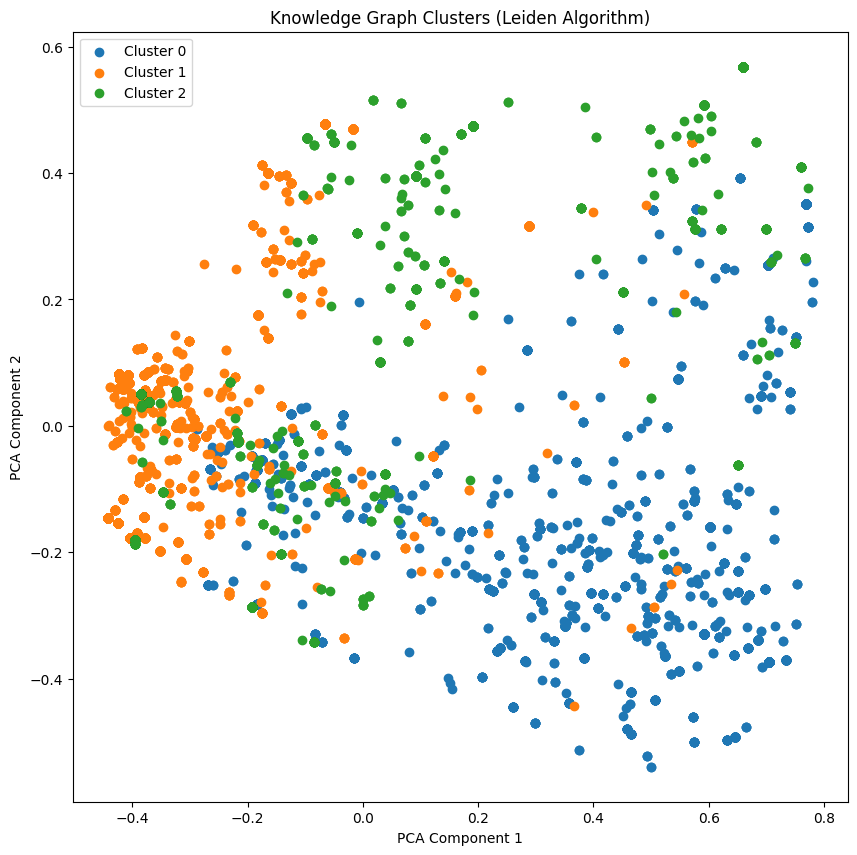

In [ ]:
heads = kg_relations['head_type'].values
relations = kg_relations['relation'].values
tails = kg_relations['tail_type'].values
# concatenate head, relation, and tail with a separator
triples = [f"{head} [SEP] {relation} [SEP] {tail}" for head, relation, tail in zip(heads, relations, tails)]

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(triples)

# visualize the clusters using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
unique_labels = np.unique(labels)
for i in unique_labels:
    cluster_points = reduced_embeddings[kg_relations['cluster'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.legend()
plt.title('Knowledge Graph Clusters (Leiden Algorithm)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [ ]:
kg_relations

,bibcode,item,label,head,head_type,relation,tail,tail_type
0,2021JGRE..12606589M,1,Crater,Apollo Basin,planetaryNomenclature,hasChild,SPA ejecta,celestialObjectRegion
1,2021JGRE..12606589M,1,Crater,Birkeland,planetaryNomenclature,hasChild,ejecta materials,celestialObjectRegion
2,2021JGRE..12606589M,1,Crater,Oresme V,planetaryNomenclature,hasChild,ejecta materials,celestialObjectRegion
3,2021JGRE..12606589M,1,Crater,volcanic resurfacing deposits,celestialObjectRegion,hasChild,mare basalts,celestialObjectRegion
4,2021JGRE..12606589M,1,Crater,volcanic resurfacing deposits,celestialObjectRegion,hasChild,Mons Marguerite,planetaryNomenclature
...,...,...,...,...,...,...,...,...
8830,2018JGRE..123.2585I,33,Crater,SPA basin,celestialObjectRegion,hasChild,oldest materials,celestialRegion
8831,2018JGRE..123.2585I,33,Crater,SPA basin,celestialObjectRegion,hasChild,strongly degraded craters,celestialRegion
8832,2018JGRE..123.2585I,33,Crater,CSFD measurements,measure,locatedIn,surface of the plain-forming rugged terrain ne...,celestialRegion
8833,2018JGRE..123.2585I,33,Crater,CSFD measurements,measure,locatedIn,surface of the plain-forming rugged unit in th...,celestialRegion


### Assign Clusters and Calculate Statistics

In this section, we assign the extracted entities from the test data to the existing clusters identified in the knowledge graph and calculate the statistics for each excerpt.

In [ ]:
def extract_number(string):
    match = re.search(r'\[(.*?)\]', string)
    if match:
        try:
          return int(match.group(1))
        except:
          return 0
    return 0

In [ ]:
kg_relations_test = load_relation('gpt4o_test_results.csv')

# assign the extracted entities to the existing clusters
assigned_clusters = []
for _, row in kg_relations_test.iterrows():
    head_type = row['head_type']
    tail_type = row['tail_type']

    # find the cluster with the most similar head and tail types
    cluster_counts = kg_relations[kg_relations['head_type'] == head_type]
    cluster_counts = cluster_counts[cluster_counts['tail_type'] == tail_type]

    if len(cluster_counts) > 0:
        cluster_index = cluster_counts['cluster'].mode()[0]
    else:
        # find the cluster with the most similar head type
        head_cluster_counts = kg_relations[kg_relations['head_type'] == head_type]
        if len(head_cluster_counts) > 0:
            cluster_index = head_cluster_counts['cluster'].mode()[0]
        else:
            # find the cluster with the most similar tail type
            tail_cluster_counts = kg_relations[kg_relations['tail_type'] == tail_type]
            if len(tail_cluster_counts) > 0:
                cluster_index = tail_cluster_counts['cluster'].mode()[0]
            else:
                cluster_index = None  # No matching cluster found

    assigned_clusters.append(cluster_index)

# add the assigned clusters to the kg_relations_test DataFrame
kg_relations_test['cluster'] = assigned_clusters

# count the number of entity-relation-entity triples belonging to each cluster for each excerpt
excerpt_clusters = defaultdict(lambda: defaultdict(int))
for _, row in kg_relations_test.iterrows():
    bibcode = row['bibcode']
    item = row['item']
    cluster = row['cluster']
    excerpt_clusters[(bibcode, item)][cluster] += 1

stats_list = [None] * len(kg_relations_test)
for idx, key in enumerate(excerpt_clusters.keys()):
    bibcode, item = key
    cluster_counts = excerpt_clusters[key]
    total_triples = sum(cluster_counts.values())
    cluster_percentages = {cluster: count / total_triples for cluster, count in cluster_counts.items()}
    stats = []
    for cluster, percentage in cluster_percentages.items():
        stats.append(f"[{cluster}]:{percentage:.2%}")
    stats = sorted(stats, key=extract_number)
    stats = ';'.join(stats)
    # assign the stats to the corresponding rows in kg_relations_test
    kg_relations_test.loc[(kg_relations_test['bibcode'] == bibcode) & (kg_relations_test['item'] == item), 'stats'] = stats

In [ ]:
kg_relations_test

,bibcode,item,label,head,head_type,relation,tail,tail_type
0,2023arXiv231013112B,0,Mission,2023 NT1,celestialObject,hasName,Apollo Near-Earth Asteroid (NEA),planetaryNomenclature
1,2023arXiv231013112B,0,Mission,2023 NT1,celestialObject,firstObserved,"July 15, 2023",period
2,2023arXiv231013112B,0,Mission,M22 ATLAS-Sutherland telescope,telescope,locatedIn,South Africa,celestialRegion
3,2023arXiv231013112B,0,Mission,2023 NT1,celestialObject,firstObserved,M22 ATLAS-Sutherland telescope,telescope
4,2023arXiv231013112B,0,Mission,2023 NT1,celestialObject,closestApproach,"July 13, 2023 at 10:13 (± 1 minute) TDB",period
...,...,...,...,...,...,...,...,...
2256,2021JGRE..12606589M,2,Crater,thorium abundance data,data,creator,"Lawrence et al., 2000, 2002b",research
2257,2021JGRE..12606589M,2,Crater,Moon Mineralogy Mapper (M3),instrument,hasUse,analyses to characterize the mineralogy of can...,research
2258,2021JGRE..12606589M,2,Crater,SPA,celestialObjectRegion,hasChild,Distribution of Thorium,celestialObjectRegion
2259,2021JGRE..12606589M,2,Crater,SPA,celestialObjectRegion,hasChild,broad enhancement in thorium abundance,measure
